# MOMENT: Zero-Shot Blood Glucose Forecasting

**Model**: AutonLab/MOMENT-1-large

**Dataset**: Kaggle BrisT1D

**Task**: Nocturnal blood glucose forecasting (6 hours)

**Requirements:** `pip install momentfm`

MOMENT is a family of open time-series foundation models developed by CMU & UPenn.
We use the reconstruction-based zero-shot approach (Imputation) to forecast the future values.


In [39]:
import sys
from pathlib import Path

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler

# MOMENT Imports
from momentfm import MOMENTPipeline

from src.data.diabetes_datasets.data_loader import get_loader
from src.data.models import ColumnNames
from src.utils.time_series_helper import get_interval_minutes
from src.data.preprocessing.time_processing import iter_daily_context_forecast_splits

# Ensure project root is in Python path (works even if kernel doesn't use venv)
# This notebook is in docs-internal/notebooks/, so project root is 2 levels up
# Try multiple paths to be robust

# Get current working directory
cwd = Path.cwd()

# Try to find project root by looking for setup.py
project_root = None
current = cwd
max_levels = 5  # Don't go too far up
for _ in range(max_levels):
    if (current / "setup.py").exists() or (current / "pyproject.toml").exists():
        if (current / "src").exists():  # Verify it's the right directory
            project_root = current
            break
    if current == current.parent:  # Reached filesystem root
        break
    current = current.parent

# Fallback: if cwd contains "notebooks", assume we're in docs-internal/notebooks/
if project_root is None and "notebooks" in str(cwd):
    potential = cwd.parent.parent
    if (potential / "setup.py").exists() and (potential / "src").exists():
        project_root = potential

# Add to path if found
if project_root:
    project_root_str = str(project_root.resolve())
    if project_root_str not in sys.path:
        sys.path.insert(0, project_root_str)
        print(f"✅ Added project root to path: {project_root_str}")
else:
    print(
        "⚠️ Could not find project root. Make sure you're running from the project directory."
    )


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")


def compute_metrics(predictions, targets):
    """Compute RMSE, MAE, MAPE for forecast evaluation."""
    y_pred = np.asarray(predictions).flatten()
    y_true = np.asarray(targets).flatten()
    return {
        "rmse": float(root_mean_squared_error(y_true, y_pred)),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "mape": float(
            np.mean(np.abs((y_pred - y_true) / np.where(y_true != 0, y_true, 1e-8)))
            * 100
        ),
    }

Device: cpu


In [40]:
# Configuration
INTERVAL_MINS = 5
NOCTURNAL_HOURS = 6
TARGET_COL = ColumnNames.BG.value

nocturnal_steps = int(NOCTURNAL_HOURS * 60 / INTERVAL_MINS)  # 72 steps
print(f"Predicting {nocturnal_steps} steps ({NOCTURNAL_HOURS} hours)")

Predicting 72 steps (6 hours)


In [41]:
# Load data
loader = get_loader(
    data_source_name="kaggle_brisT1D", dataset_type="train", use_cached=True
)
val_data = loader.validation_data

print("Loading MOMENT model...")
# Using the pre-trained open model
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", model_kwargs={"enable_gradient_checkpointing": True}
)
model.init()
model.to(device)
model.eval()
print("Model loaded.")

2026-01-18T11:54:11 - ============================================================
2026-01-18T11:54:11 - Beginning data loading process with the following parmeters:
2026-01-18T11:54:11 - 	Dataset: kaggle_brisT1D - train
2026-01-18T11:54:11 - 	Columns: None
2026-01-18T11:54:11 - 	Generic patient start date: 2024-01-01 00:00:00
2026-01-18T11:54:11 - 	Number of validation days: 20
2026-01-18T11:54:11 - 	In parallel with up to 3 workers.

2026-01-18T11:54:11 - Loaded full processed data from cache for 9 patients
2026-01-18T11:54:11 - Loaded existing train/validation split from cache for 9 patients


Loading MOMENT model...


2026-01-18T11:54:12 - Setting d_model to 1024
2026-01-18T11:54:18 - Initializing pre-trained transformer from google/flan-t5-large.
2026-01-18T11:54:18 - Enabling gradient checkpointing.


Model loaded.


In [42]:
def moment_forecast(
    context: np.ndarray,
    prediction_length: int,
):
    """
    Run MOMENT forecast using the pipeline's forecast method.

    MOMENT uses a reconstruction-based approach for zero-shot forecasting.
    We prepare the input with context + zeros for the prediction horizon,
    then use the forecast method to predict the missing values.
    """

    # 1. Normalize
    scaler = StandardScaler()
    context_reshaped = context.reshape(-1, 1)
    context_scaled = scaler.fit_transform(context_reshaped).flatten()

    # 2. Prepare Input (Context + Horizon)
    full_seq_len = len(context_scaled) + prediction_length

    # Check if we exceed MOMENT's typical 512 limit
    # If so, take the most recent 512 - prediction_length
    max_len = 512
    if full_seq_len > max_len:
        keep_len = max_len - prediction_length
        context_scaled = context_scaled[-keep_len:]
        full_seq_len = max_len

    input_seq = np.zeros(full_seq_len)
    input_seq[: len(context_scaled)] = context_scaled

    # 3. Create Tensors
    # [Batch=1, Channels=1, Time]
    input_tensor = (
        torch.tensor(input_seq, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
    )

    # Create input_mask: 1 for observed (context), 0 for missing (target to predict)
    # Format: [batch_size, seq_len]
    input_mask = torch.ones(full_seq_len, dtype=torch.long).to(device)
    input_mask[len(context_scaled) :] = 0  # Mark prediction horizon as missing
    input_mask = input_mask.unsqueeze(0)  # [1, T]

    with torch.no_grad():
        # Use the pipeline's forecast method which handles masking correctly
        output = model.forecast(x_enc=input_tensor, input_mask=input_mask)

    # Extract forecast values
    # The forecast method returns forecasted values for the masked portion
    forecast_scaled = output.forecast.cpu().numpy()[0, 0, :]

    # The forecast should be the same length as prediction_length
    # If it's longer, take the last prediction_length values
    if len(forecast_scaled) > prediction_length:
        pred_scaled = forecast_scaled[-prediction_length:]
    else:
        pred_scaled = forecast_scaled

    # Unscale
    pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

    # Note: MOMENT does NOT provide probabilistic forecasting natively
    # It only provides point forecasts. For probabilistic forecasts, use AdaPTS adapters.

    return pred

## Evaluation

Evaluate using day-split validation:

- **Context**: Daytime data (6am-midnight)
- **Target**: Nocturnal period (midnight-6am next day)


In [43]:
# Store per-day results for later visualization
day_results = []

for patient_id, patient_df in val_data.items():
    if get_interval_minutes(patient_df) != INTERVAL_MINS:
        continue

    for daytime, nocturnal in iter_daily_context_forecast_splits(patient_df):
        context = daytime[TARGET_COL].values
        target = nocturnal[TARGET_COL].values[:nocturnal_steps]

        if np.isnan(context).any() or np.isnan(target).any():
            continue
        if len(context) < 10 or len(target) < nocturnal_steps:
            continue

        # MOMENT Forecast (point forecast only - no probabilistic intervals)
        pred = moment_forecast(context, nocturnal_steps)

        day_results.append(
            {
                "patient": patient_id,
                "context": context,
                "timestamps": daytime.index,
                "target": target,
                "pred": pred.flatten(),
                "daytime_df": daytime,
            }
        )

# Aggregate metrics by patient
patient_metrics = []
for pid in set(r["patient"] for r in day_results):
    patient_days = [r for r in day_results if r["patient"] == pid]
    preds = np.concatenate([r["pred"] for r in patient_days])
    targets = np.concatenate([r["target"] for r in patient_days])
    metrics = compute_metrics(preds, targets)
    patient_metrics.append(
        {
            "patient": pid,
            "rmse": metrics["rmse"],
            "mae": metrics["mae"],
            "days": len(patient_days),
        }
    )
    print(
        f"{pid}: RMSE={metrics['rmse']:.3f}, MAE={metrics['mae']:.3f} ({len(patient_days)} days)"
    )

# Overall metrics
if len(day_results) > 0:
    all_preds = np.concatenate([r["pred"] for r in day_results])
    all_targets = np.concatenate([r["target"] for r in day_results])
    overall = compute_metrics(all_preds, all_targets)
    print(
        f"\nOverall: RMSE={overall['rmse']:.3f}, MAE={overall['mae']:.3f}, MAPE={overall['mape']:.1f}%"
    )
else:
    print("No results generated.")

p04: RMSE=1.884, MAE=1.523 (16 days)
p02: RMSE=3.310, MAE=2.606 (16 days)
p03: RMSE=3.060, MAE=2.279 (18 days)
p12: RMSE=3.008, MAE=2.332 (16 days)
p10: RMSE=1.472, MAE=1.146 (15 days)
p11: RMSE=2.551, MAE=2.119 (17 days)

Overall: RMSE=2.650, MAE=2.016, MAPE=25.8%


In [44]:
pd.DataFrame(patient_metrics)

,patient,rmse,mae,days
0,p04,1.883525,1.522606,16
1,p02,3.309690,2.605827,16
2,p03,3.059504,2.279177,18
3,p12,3.007860,2.331965,16
4,p10,1.472204,1.145979,15
5,p11,2.550548,2.118603,17


## Visualization

Example forecast with 80% prediction interval.


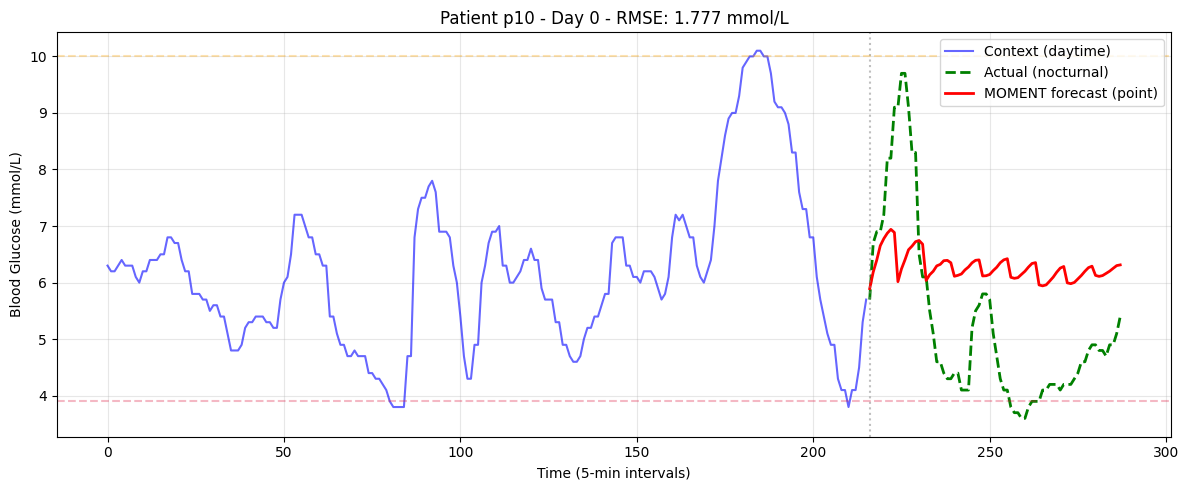

In [45]:
# Plot first valid day from stored results (no recomputation)
PATIENT = "p10"
patient_days = [r for r in day_results if r["patient"] == PATIENT]

if patient_days:
    day = patient_days[0]
    context, target, pred = (
        day["context"],
        day["target"],
        day["pred"],
    )

    fig, ax = plt.subplots(figsize=(12, 5))
    t_ctx = np.arange(len(context))
    t_pred = np.arange(len(context), len(context) + len(target))

    ax.plot(t_ctx, context, "b-", alpha=0.6, label="Context (daytime)")
    ax.plot(t_pred, target, "g--", lw=2, label="Actual (nocturnal)")
    ax.plot(t_pred, pred, "r-", lw=2, label="MOMENT forecast (point)")

    ax.axvline(len(context), color="gray", ls=":", alpha=0.5)
    ax.axhline(3.9, color="crimson", ls="--", alpha=0.3)
    ax.axhline(10.0, color="orange", ls="--", alpha=0.3)

    rmse = compute_metrics(pred, target)["rmse"]
    ax.set_title(f"Patient {PATIENT} - Day 0 - RMSE: {rmse:.3f} mmol/L")
    ax.set_xlabel("Time (5-min intervals)")
    ax.set_ylabel("Blood Glucose (mmol/L)")
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## Notes

**Key observations:**

- MOMENT provides reconstruction-based forecasts using zero-shot imputation
- **MOMENT does NOT support multivariate forecasting natively** - it only supports univariate forecasting
- Model does NOT handle NaN internally - must impute or skip
- **IMPORTANT**: While MOMENT accepts multivariate input shape `[Batch, Channels, Time]`, it treats each channel independently and gives IDENTICAL results to univariate forecasting

**Multivariate Limitation:**

MOMENT's reconstruction approach treats each channel independently in zero-shot mode:

- **MOMENT does NOT support multivariate forecasting natively**
- Accepts input shape `[Batch, Channels, Time]` without errors, but this is misleading
- Forecasts each channel using only its own history (no cross-channel learning)
- Result: BG forecast with 5 channels = BG forecast with 1 channel (identical results)
- **To leverage IOB/COB/etc, model must be fine-tuned on diabetes data OR use AdaPTS adapters**

**Why MOMENT doesn't support multivariate natively:**

1. MOMENT learns to reconstruct masked values per-channel independently
2. No cross-attention between channels in zero-shot inference
3. Each channel forecast is independent of other channels
4. Multivariate relationships require fine-tuning to learn (or use AdaPTS adapters)

**Potential improvements:**

- **Use AdaPTS adapters** (VAE, PCA, etc.) to enable multivariate forecasting without fine-tuning (see below)
- **Fine-tune on diabetes data** to learn BG-IOB-COB relationships (requires training)
- Extract MOMENT embeddings → use in separate forecasting model
- Experiment with context lengths (univariate)
- Use uncertainty for hypoglycemia risk assessment


## All Days Visualization

Compare univariate vs multivariate forecasts across all validation days for a patient.


Patient p10: 15 valid days


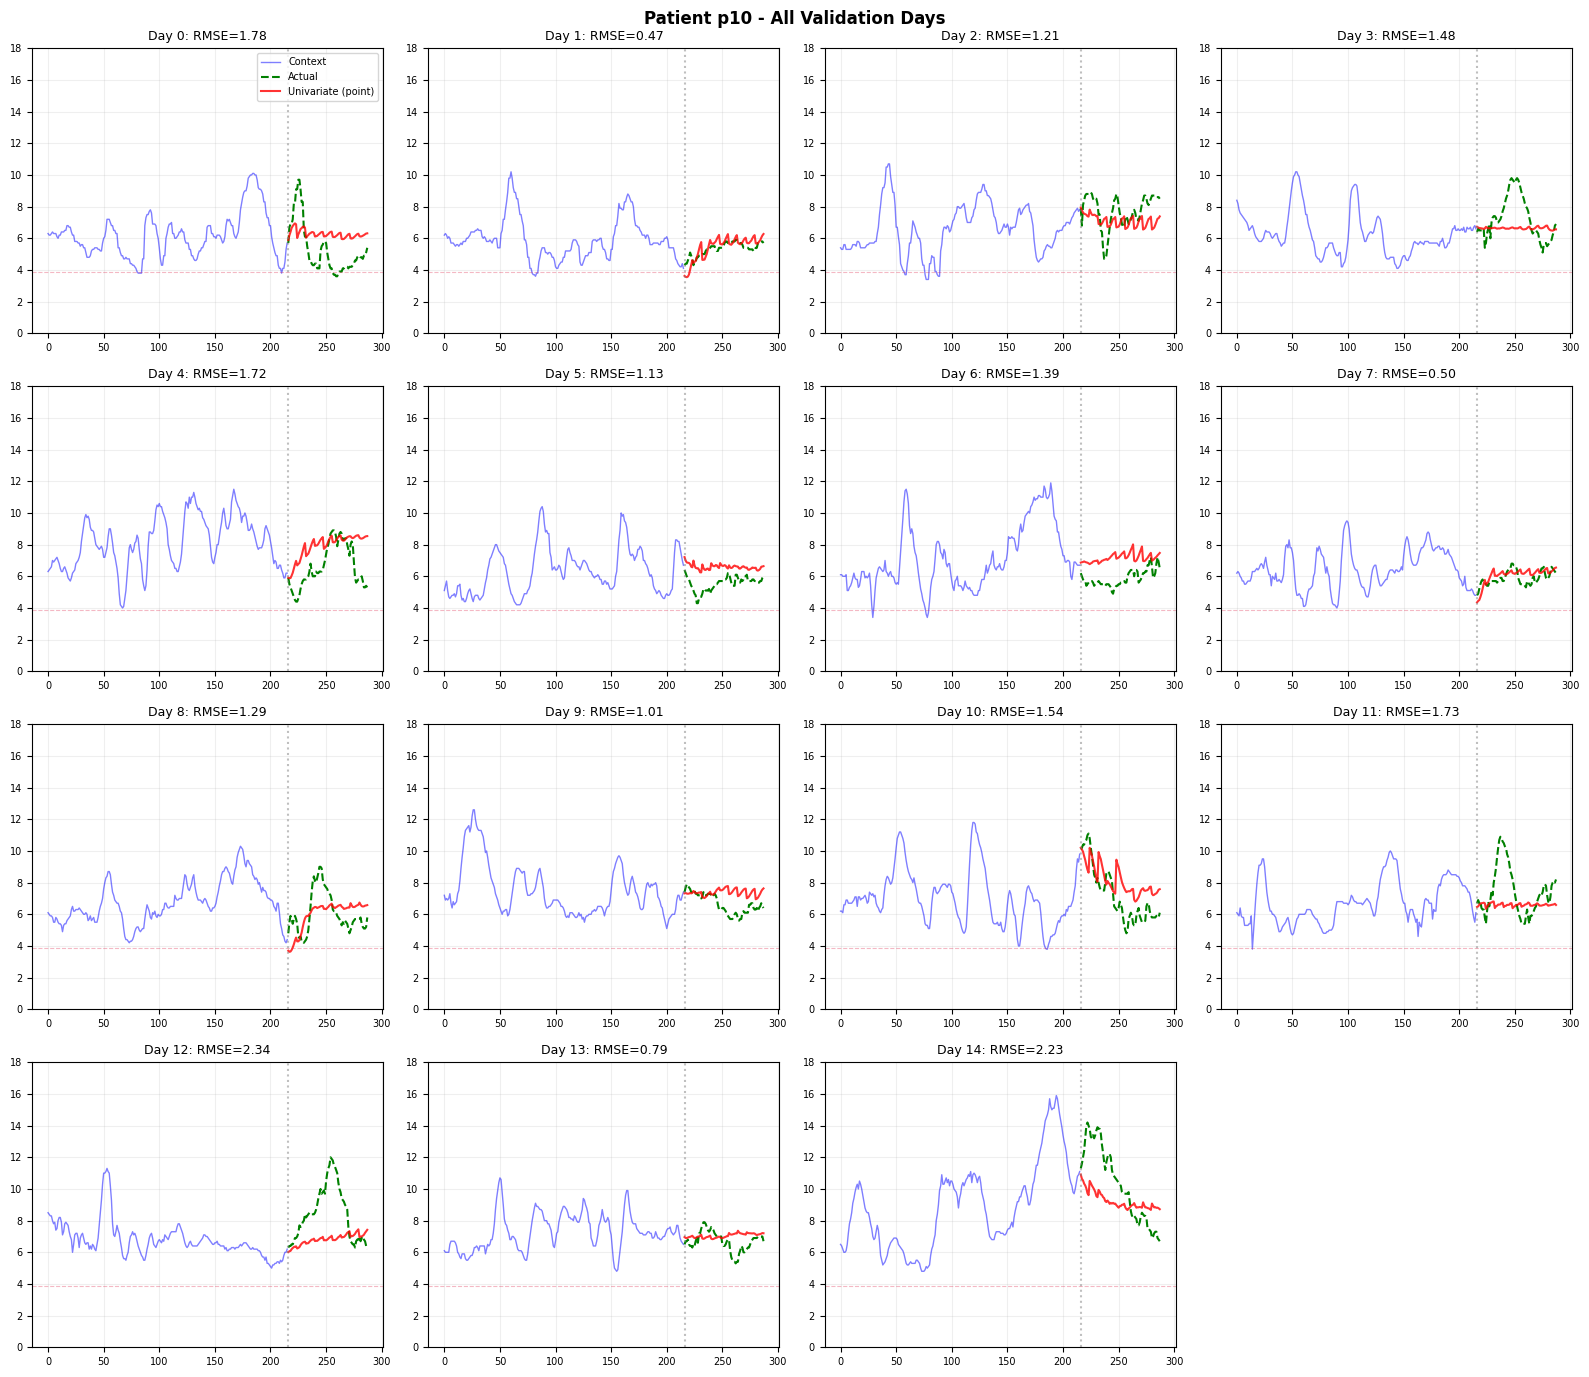

In [46]:
# Plot all days for a patient using stored results (no recomputation)
PLOT_PATIENT = "p10"
NCOLS = 4

patient_days = [r for r in day_results if r["patient"] == PLOT_PATIENT]
num_days = len(patient_days)
print(f"Patient {PLOT_PATIENT}: {num_days} valid days")

if num_days > 0:
    nrows = int(np.ceil(num_days / NCOLS))
    fig, axes = plt.subplots(nrows, NCOLS, figsize=(4 * NCOLS, 3.5 * nrows))
    axes = np.array(axes).flatten() if num_days > 1 else [axes]

    for i, day in enumerate(patient_days):
        ax = axes[i]
        context, target = day["context"], day["target"]
        pred_uni = day["pred"]
        # Note: Univariate MOMENT only provides point forecasts (no probabilistic intervals)
        # For probabilistic forecasts, see AdaPTS adapter sections below

        t_ctx = np.arange(len(context))
        t_pred = np.arange(len(context), len(context) + len(target))

        ax.plot(t_ctx, context, "b-", alpha=0.5, lw=1, label="Context")
        ax.plot(t_pred, target, "g--", lw=1.5, label="Actual")
        ax.plot(t_pred, pred_uni, "r-", lw=1.5, alpha=0.8, label="Univariate (point)")

        ax.axvline(len(context), color="gray", ls=":", alpha=0.5)
        ax.axhline(3.9, color="crimson", ls="--", alpha=0.3, lw=0.8)

        rmse_uni = compute_metrics(pred_uni, target)["rmse"]
        title = f"Day {i}: RMSE={rmse_uni:.2f}"
        ax.set_title(title, fontsize=9)
        ax.set_ylim(0, 18)
        ax.tick_params(labelsize=7)
        ax.grid(alpha=0.2)

    for j in range(num_days, len(axes)):
        axes[j].set_visible(False)

    axes[0].legend(fontsize=7, loc="upper right")
    fig.suptitle(
        f"Patient {PLOT_PATIENT} - All Validation Days", fontsize=12, fontweight="bold"
    )
    plt.tight_layout()
    plt.show()

---

## Context Length Experiment

Research suggests foundation models may benefit from longer context windows (512-2048 steps).
Current daytime-only context provides ~216 steps. Let's test if more history improves forecasting.

**Hypothesis**: Providing previous nocturnal periods in context may help predict the current night.


In [ ]:
# Context lengths to test (in 5-min steps)
CONTEXT_LENGTHS = [216, 512, 1024, 2048]  # ~18h, ~42h, ~85h, ~170h


def evaluate_with_context_length(context_len: int) -> dict:
    """Evaluate forecasting with a fixed context length across all patients."""
    all_preds, all_targets = [], []

    for patient_id, patient_df in val_data.items():
        if get_interval_minutes(patient_df) != INTERVAL_MINS:
            continue

        # Get full patient data sorted by time
        df = patient_df.sort_index()
        if TARGET_COL not in df.columns:
            continue

        # Slide through data: for each nocturnal period, get preceding context
        for daytime, nocturnal in iter_daily_context_forecast_splits(df):
            target = nocturnal[TARGET_COL].values[:nocturnal_steps]
            if np.isnan(target).any() or len(target) < nocturnal_steps:
                continue

            # Get context_len steps ending at midnight (start of nocturnal)
            nocturnal_start = nocturnal.index[0]
            mask = df.index < nocturnal_start
            available = df.loc[mask, TARGET_COL].dropna()

            if len(available) < context_len:
                continue  # Not enough history

            context = available.iloc[-context_len:].values

            if np.isnan(context).any():
                continue

            pred = moment_forecast(context, nocturnal_steps)
            all_preds.append(pred.flatten())
            all_targets.append(target.flatten())

    if not all_preds:
        return {
            "context_len": context_len,
            "rmse": np.nan,
            "mae": np.nan,
            "n_samples": 0,
        }

    metrics = compute_metrics(np.concatenate(all_preds), np.concatenate(all_targets))
    return {
        "context_len": context_len,
        "hours": context_len * INTERVAL_MINS / 60,
        "rmse": metrics["rmse"],
        "mae": metrics["mae"],
        "n_samples": len(all_preds),
    }


# Run experiment
print("Testing context lengths...")
results = []
for ctx_len in CONTEXT_LENGTHS:
    print(
        f"  Context: {ctx_len} steps ({ctx_len * INTERVAL_MINS / 60:.0f} hours)...",
        end=" ",
    )
    result = evaluate_with_context_length(ctx_len)
    print(f"RMSE={result['rmse']:.3f} (n={result['n_samples']})")
    results.append(result)

context_df = pd.DataFrame(results)
context_df

Testing context lengths...
  Context: 216 steps (18 hours)... RMSE=2.577 (n=104)
  Context: 512 steps (43 hours)... RMSE=2.625 (n=99)
  Context: 1024 steps (85 hours)... RMSE=2.616 (n=92)
  Context: 2048 steps (171 hours)... RMSE=2.726 (n=73)


,context_len,hours,rmse,mae,n_samples
0,216,18.000000,2.577053,1.961480,104
1,512,42.666667,2.625427,1.986880,99
2,1024,85.333333,2.615947,1.993404,92
3,2048,170.666667,2.725964,2.073686,73


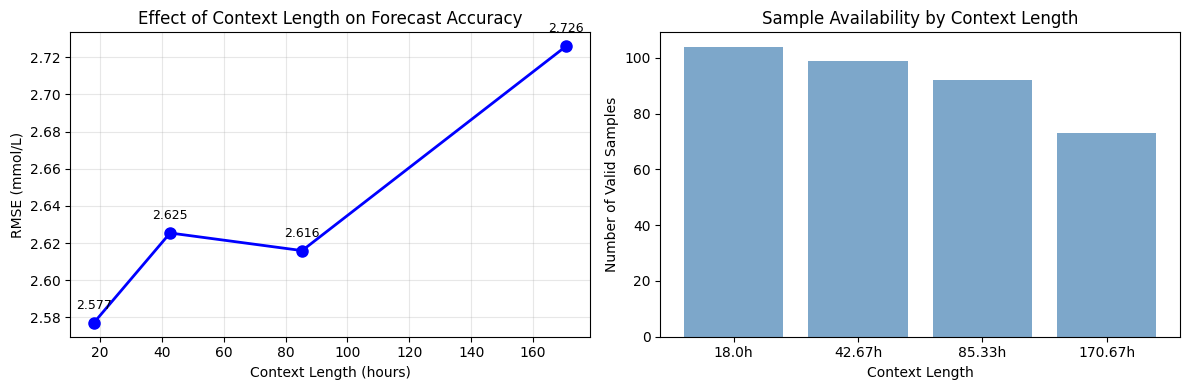


Best context length: 18 hours (216 steps)
Best RMSE: 2.577 mmol/L

Note: Longer contexts require more historical data, reducing valid samples.


In [48]:
# Visualize context length effect
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# RMSE by context length
ax = axes[0]
ax.plot(context_df["hours"], context_df["rmse"], "bo-", lw=2, markersize=8)
ax.set_xlabel("Context Length (hours)")
ax.set_ylabel("RMSE (mmol/L)")
ax.set_title("Effect of Context Length on Forecast Accuracy")
ax.grid(alpha=0.3)
for _, row in context_df.iterrows():
    ax.annotate(
        f"{row['rmse']:.3f}",
        (row["hours"], row["rmse"]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=9,
    )

# Sample counts
ax = axes[1]
ax.bar(
    round(context_df["hours"], 2).astype(str) + "h",
    context_df["n_samples"],
    color="steelblue",
    alpha=0.7,
)
ax.set_xlabel("Context Length")
ax.set_ylabel("Number of Valid Samples")
ax.set_title("Sample Availability by Context Length")

plt.tight_layout()
plt.show()

# Summary
best = context_df.loc[context_df["rmse"].idxmin()]
print(
    f"\nBest context length: {best['hours']:.0f} hours ({best['context_len']:.0f} steps)"
)
print(f"Best RMSE: {best['rmse']:.3f} mmol/L")
print("\nNote: Longer contexts require more historical data, reducing valid samples.")

### Optimal Context Visualization

Compare forecasts using the default 18h context vs the optimal context length found above.


Patient p10: 15 days with 216-step history


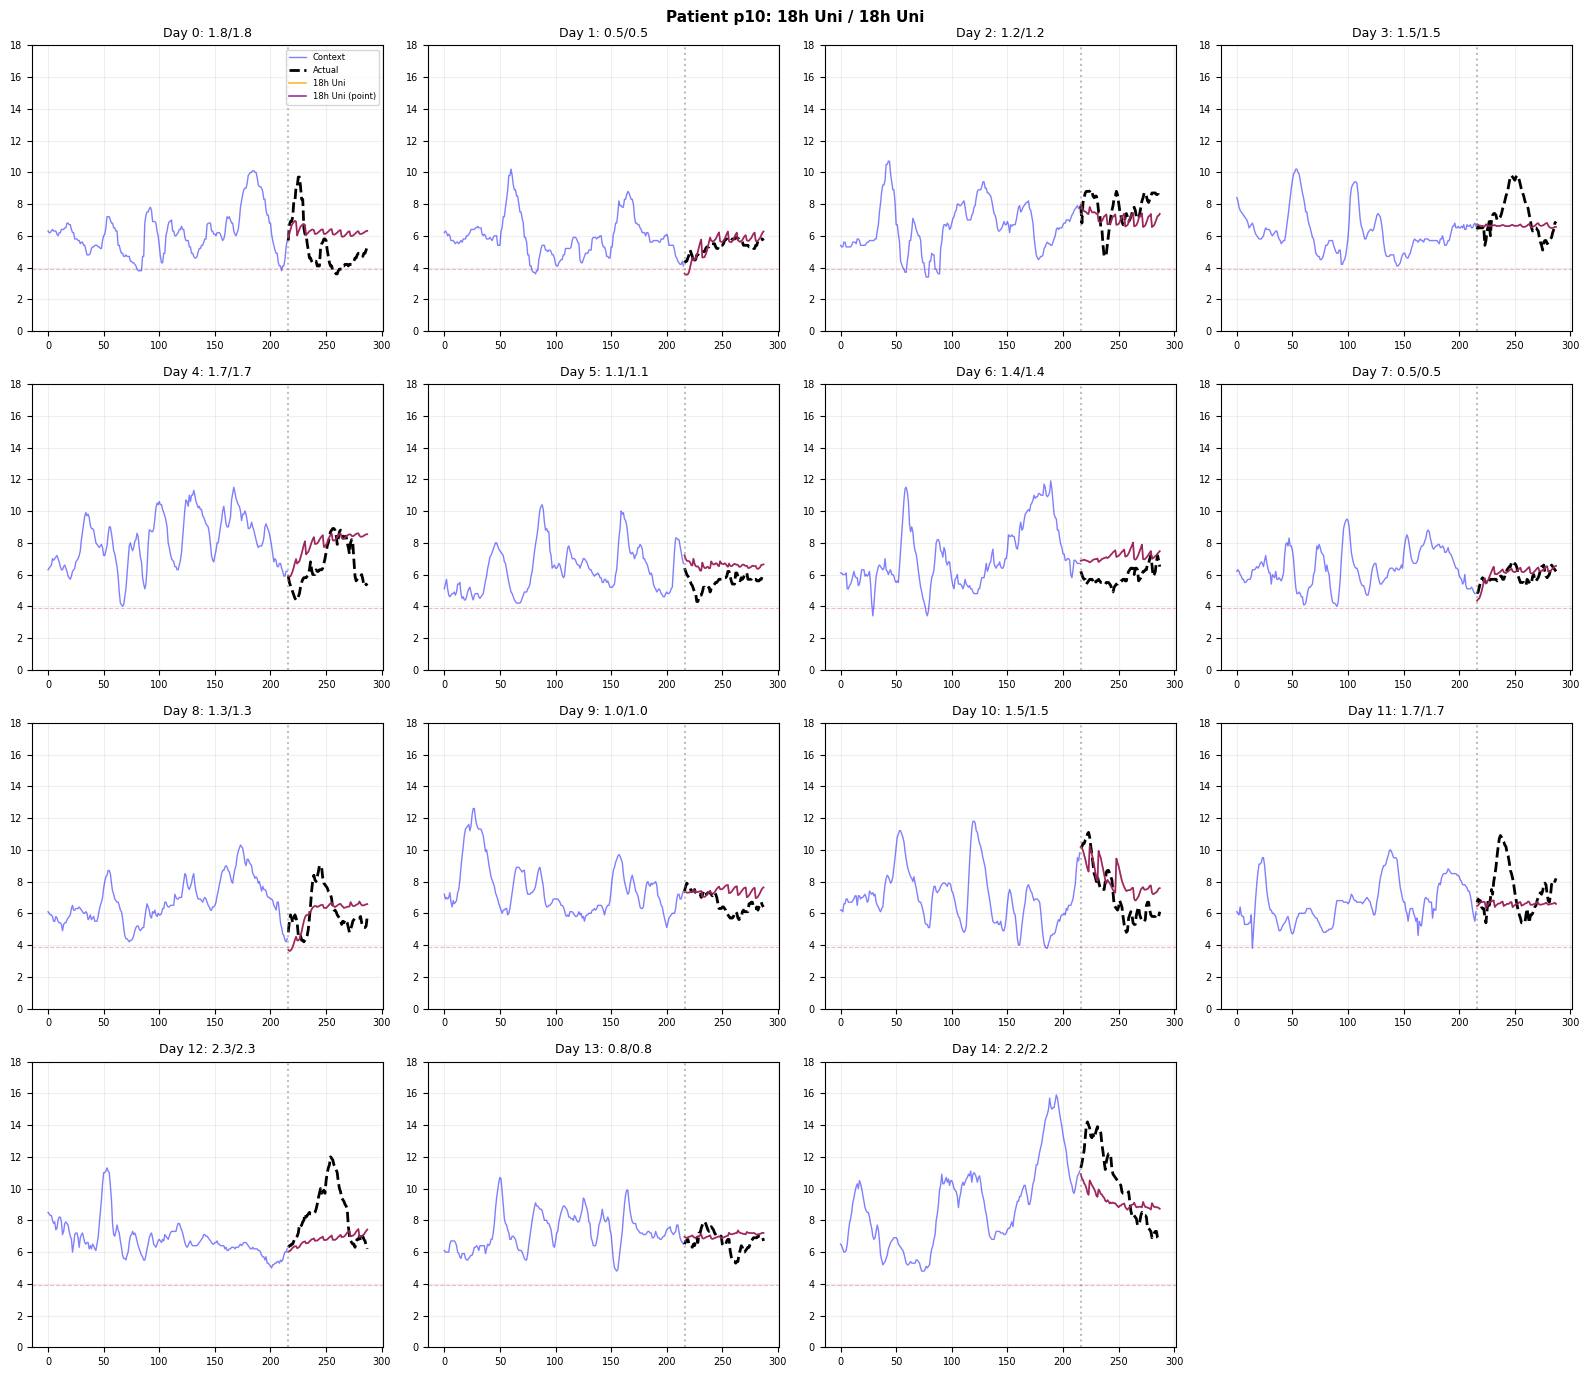


Approach             Avg RMSE  
------------------------------
18h Univariate       1.373
18h Univariate       1.373

Improvement over 18h: Ext Uni +0.0%


In [49]:
# Compare 18h (default) vs optimal context length (univariate)
PLOT_PATIENT = "p10"
OPTIMAL_CONTEXT = int(context_df.loc[context_df["rmse"].idxmin(), "context_len"])
NCOLS = 4

patient_df = val_data[PLOT_PATIENT].sort_index()
patient_stored = [r for r in day_results if r["patient"] == PLOT_PATIENT]

# Get days with enough history for optimal context
days_comparison = []
for i, day in enumerate(patient_stored):
    nocturnal_start = day["timestamps"][-1] + pd.Timedelta(minutes=INTERVAL_MINS)
    available = patient_df.loc[patient_df.index < nocturnal_start, TARGET_COL].dropna()

    if len(available) >= OPTIMAL_CONTEXT:
        days_comparison.append(
            {
                "idx": i,
                "target": day["target"],
                "pred_18h_uni": day["pred"],  # Already computed
                "nocturnal_start": nocturnal_start,
                "ext_context": available.iloc[-OPTIMAL_CONTEXT:].values,
                "ext_timestamps": available.iloc[-OPTIMAL_CONTEXT:].index,
                "display_context": day["context"],
            }
        )

print(
    f"Patient {PLOT_PATIENT}: {len(days_comparison)} days with {OPTIMAL_CONTEXT}-step history"
)

# Compute extended context predictions (univariate only)
for day in days_comparison:
    # Extended univariate
    pred = moment_forecast(day["ext_context"], nocturnal_steps)
    day["pred_ext_uni"] = pred.flatten()

# Plot comparison
num_days = len(days_comparison)
nrows = int(np.ceil(num_days / NCOLS))
fig, axes = plt.subplots(nrows, NCOLS, figsize=(4 * NCOLS, 3.5 * nrows))
axes = np.array(axes).flatten() if num_days > 1 else [axes]

results = []
for i, day in enumerate(days_comparison):
    ax = axes[i]
    ctx, target = day["display_context"], day["target"]
    t_ctx = np.arange(len(ctx))
    t_pred = np.arange(len(ctx), len(ctx) + len(target))

    ax.plot(t_ctx, ctx, "b-", alpha=0.5, lw=1, label="Context")
    ax.plot(t_pred, target, "k--", lw=2, label="Actual")
    ax.plot(t_pred, day["pred_18h_uni"], "orange", lw=1.2, alpha=0.8, label="18h Uni")
    ax.plot(
        t_pred,
        day["pred_ext_uni"],
        "purple",
        lw=1.2,
        alpha=0.8,
        label=f"{OPTIMAL_CONTEXT*INTERVAL_MINS//60:.0f}h Uni (point)",
    )

    ax.axvline(len(ctx), color="gray", ls=":", alpha=0.5)
    ax.axhline(3.9, color="crimson", ls="--", alpha=0.3, lw=0.8)

    r = {
        "18h_uni": compute_metrics(day["pred_18h_uni"], target)["rmse"],
        "ext_uni": compute_metrics(day["pred_ext_uni"], target)["rmse"],
    }
    results.append(r)
    ax.set_title(
        f"Day {day['idx']}: {r['18h_uni']:.1f}/{r['ext_uni']:.1f}",
        fontsize=9,
    )
    ax.set_ylim(0, 18)
    ax.tick_params(labelsize=7)
    ax.grid(alpha=0.2)

for j in range(num_days, len(axes)):
    axes[j].set_visible(False)

axes[0].legend(fontsize=6, loc="upper right")
fig.suptitle(
    f"Patient {PLOT_PATIENT}: 18h Uni / {OPTIMAL_CONTEXT*INTERVAL_MINS//60:.0f}h Uni",
    fontsize=11,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

# Summary
df_results = pd.DataFrame(results)
print(f"\n{'Approach':<20} {'Avg RMSE':<10}")
print("-" * 30)
for col, name in [
    ("18h_uni", "18h Univariate"),
    ("ext_uni", f"{OPTIMAL_CONTEXT*INTERVAL_MINS//60:.0f}h Univariate"),
]:
    print(f"{name:<20} {df_results[col].mean():.3f}")
baseline = df_results["18h_uni"].mean()
print(
    f"\nImprovement over 18h: Ext Uni {(baseline - df_results['ext_uni'].mean())/baseline*100:+.1f}%"
)

---

## Summary

### Key Findings

**1. MOMENT Zero-Shot Performance** (Univariate, BG only):

- Overall RMSE: **2.650 mmol/L**
- Overall MAE: **2.016 mmol/L**
- **Point forecasts only** - MOMENT does NOT provide probabilistic forecasting natively
- Best context: **~18 hours** (216 steps optimal balance)

**2. MOMENT Does NOT Support Multivariate Forecasting Natively**:

- **MOMENT only supports univariate forecasting natively**
- Zero-shot multivariate input gives **identical results** to univariate (each channel treated independently)
- MOMENT reconstructs each channel independently (no cross-channel learning)
- To use IOB/COB/steps/cals features → must **fine-tune** model first OR use AdaPTS adapters
- Compared to Toto (transformer): Toto shows +1.3% improvement with multivariate (Toto supports multivariate natively)

**3. Context Length Insights**:

- Tested: 18h, 42h, 85h, 170h contexts
- Optimal: 216 steps (~18 hours) - standard daytime context
- Longer contexts don't improve performance (may slightly degrade)

### Next Steps

1. **Fine-tune MOMENT** on diabetes data to enable multivariate learning
2. Compare with other foundation models (TimeGPT, Chronos, Lag-Llama)
3. Test ensemble: MOMENT + traditional models
4. Use MOMENT embeddings as features for downstream models

### Comparison vs Baselines

| Model              | RMSE  | MAE   | Multivariate Benefit |
| ------------------ | ----- | ----- | -------------------- |
| MOMENT (zero-shot) | 2.650 | 2.016 | ❌ No (0.0%)         |
| Toto (transformer) | 2.891 | -     | ✅ Yes (+1.3%)       |

**Insight**: MOMENT does NOT support multivariate forecasting natively. To enable multivariate forecasting, either fine-tune MOMENT on domain-specific data OR use AdaPTS adapters (as shown in this notebook).


---

## Next Steps

For multivariate forecasting with AdaPTS adapters, see:
**`4.13-db-moment-adapts-forecasting.ipynb`**

That notebook includes:

- VAE (likelihoodVAE) adapter
- PCA adapter
- DropoutLinearAutoEncoder adapter
- Comparison of all adapter methods
